<a href="https://colab.research.google.com/github/yussif-issah/css54FinalProject/blob/main/visontransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 2.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [3]:
!pip install transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 24.4 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [29]:
import torch
import torchvision
from torchvision import transforms
from datasets import load_dataset
from transformers import ViTImageProcessor,ViTForImageClassification, Trainer, TrainingArguments
import numpy as np
from sklearn.metrics import accuracy_score,confusion_matrix ,ConfusionMatrixDisplay,classification_report
import matplotlib.pyplot as plt

In [5]:
train_dataset = load_dataset("imagefolder", data_dir="/content/drive/MyDrive/datamangrove/train",split="train")
validation_dataset = load_dataset("imagefolder", data_dir="/content/drive/MyDrive/datamangrove/val",split="train")
test_dataset = load_dataset("imagefolder", data_dir="/content/drive/MyDrive/datamangrove/test",split="train")

Resolving data files:   0%|          | 0/208 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Resolving data files:   0%|          | 0/61 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Resolving data files:   0%|          | 0/31 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [6]:
itos = dict((k,v) for k,v in enumerate(train_dataset.features['label'].names))
stoi = dict((v,k) for k,v in enumerate(train_dataset.features['label'].names))
itos

{0: 'Avicennia Alba', 1: 'Rhizophora Apiculata', 2: 'Sonneratia Alba'}

In [7]:
model_name = "google/vit-base-patch16-224"
processor = ViTImageProcessor.from_pretrained(model_name)

mu, sigma = processor.image_mean, processor.image_std #get default mu,sigma
size = processor.size

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [8]:
norm = transforms.Normalize(mean=mu, std=sigma)

_transf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    norm
])


def transf(arg):
    arg['pixels'] = [_transf(image.convert('RGB')) for image in arg['image']]
    return arg

In [9]:
model = ViTForImageClassification.from_pretrained(model_name, num_labels=3, ignore_mismatched_sizes=True, id2label=itos, label2id=stoi)
print(model.classifier)

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Linear(in_features=768, out_features=3, bias=True)


In [10]:
train_dataset.set_transform(transf)
validation_dataset.set_transform(transf)
test_dataset.set_transform(transf)


In [11]:
args = TrainingArguments(
    f"test ",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_dir='logs',
    remove_unused_columns=False,
)

In [12]:
def collate_fn(examples):
    pixels = torch.stack([example["pixels"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixels, "labels": labels}

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels))

In [13]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

In [14]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.197511,1.000000
2,No log,0.020438,1.000000
3,No log,0.007516,1.000000
4,No log,0.005437,1.000000
5,No log,0.004257,1.000000
6,No log,0.003639,1.000000
7,No log,0.003306,1.000000
8,No log,0.003099,1.000000
9,No log,0.002985,1.000000
10,No log,0.002942,1.000000


TrainOutput(global_step=210, training_loss=0.06798681985764277, metrics={'train_runtime': 265.6504, 'train_samples_per_second': 7.83, 'train_steps_per_second': 0.791, 'total_flos': 1.6118478303363072e+17, 'train_loss': 0.06798681985764277, 'epoch': 10.0})

In [15]:
outputs = trainer.predict(test_dataset)
outputs.metrics
print(outputs)

PredictionOutput(predictions=array([[ 1.8360554 , -1.2577986 , -1.7104629 ],
       [ 1.5904245 , -1.6553638 , -1.3723968 ],
       [ 1.9264696 , -1.2142636 , -1.8660876 ],
       [ 1.3271716 , -0.82144976, -1.8010314 ],
       [ 1.5166115 , -0.8142166 , -1.3960843 ],
       [ 1.7444288 , -1.5658664 , -2.0699205 ],
       [ 1.9599676 , -2.1282754 , -1.4274004 ],
       [ 1.9295967 , -2.031752  , -1.8482134 ],
       [ 1.800876  , -2.2716744 , -1.8680238 ],
       [ 1.5207405 , -2.134243  , -1.704811  ],
       [-1.2260498 ,  1.3436993 , -0.28596485],
       [-1.2179923 ,  0.93282807, -0.7769042 ],
       [-1.199535  ,  1.6759154 , -0.37141624],
       [-1.5427375 ,  0.8735053 , -0.19391502],
       [-1.2746536 ,  0.81093067, -0.30859098],
       [-1.4803357 ,  0.42139623, -1.2465296 ],
       [-1.3917449 ,  1.7353203 , -0.57930535],
       [-1.5401777 ,  1.1426829 , -1.3076472 ],
       [-1.2291721 ,  0.52490205, -0.60054845],
       [-1.4168754 ,  0.819001  , -0.91650814],
       [-1.

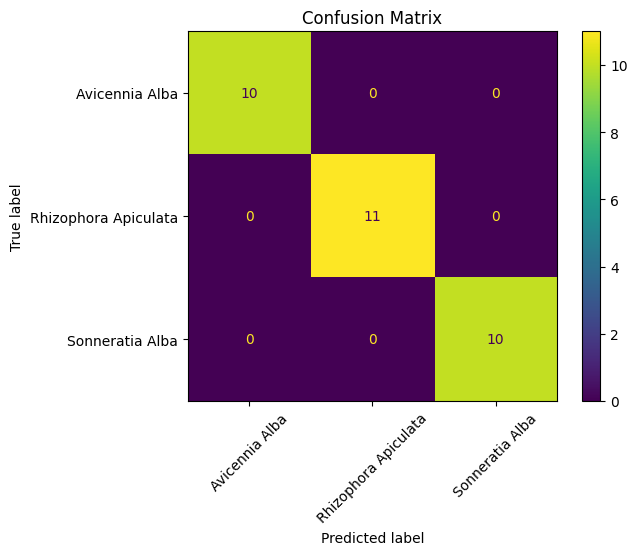

                      precision    recall  f1-score   support

      Avicennia Alba       1.00      1.00      1.00        10
Rhizophora Apiculata       1.00      1.00      1.00        11
     Sonneratia Alba       1.00      1.00      1.00        10

            accuracy                           1.00        31
           macro avg       1.00      1.00      1.00        31
        weighted avg       1.00      1.00      1.00        31



In [31]:
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = train_dataset.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()
report = classification_report(y_true, y_pred, target_names=labels)
print(report)

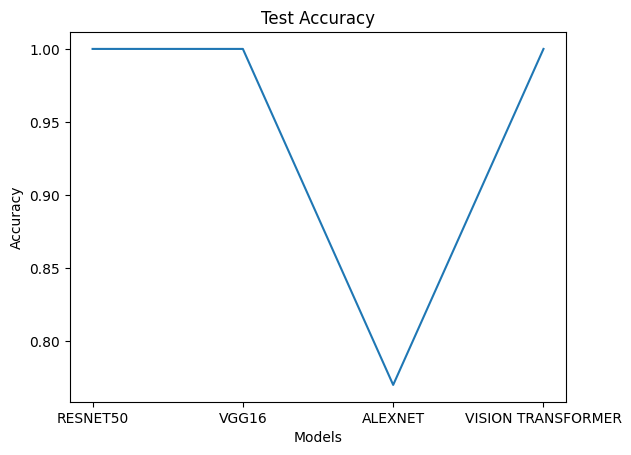

In [35]:
models=['RESNET50','VGG16','ALEXNET','VISION TRANSFORMER']
test_acc=[1,1,0.77,1]
plt.plot(models,test_acc)
plt.title("Test Accuracy")
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.show()